In [15]:
import numpy as np
import xarray as xr
from datetime import datetime
from dask.dot import dot_graph

# Create some sample data
This is just some random data, with 3 dimensions: x, y and time - designed to be a simple example that is a bit similar to the actual data we use. We save it out to a .nc file.

In [16]:
data = np.random.rand(100, 100)

In [17]:
b = xr.DataArray(data, dims=['x', 'y'], coords={'time':datetime(2010, 1, 4)})
c = xr.DataArray(data*2, dims=['x', 'y'], coords={'time':datetime(2010, 1, 5)})
d = xr.DataArray(data*3, dims=['x', 'y'], coords={'time':datetime(2010, 1, 6)})

In [19]:
a = xr.concat([b, c, d], 'time')

In [21]:
ds = a.to_dataset(name='data')

In [22]:
ds.to_netcdf('XArrayExample.nc')

# Now we load it in and start processing

In [28]:
data = xr.open_dataset('XArrayExample.nc', chunks={'x': 50, 'y': 50})['data']

We can look at it to check it is using dask etc

In [29]:
data

<xarray.DataArray 'data' (time: 3, x: 100, y: 100)>
dask.array<XArrayE..., shape=(3, 100, 100), dtype=float64, chunksize=(3, 50, 50)>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-04 2010-01-05 2010-01-06
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

We can look at the number of chunks that it is split into

In [30]:
data.chunks

((3,), (50, 50), (50, 50))

This basically shows that we have a single chunk down the 'time' axis, which is 3 long, and then two chunks each for 'x' and 'y', each of which are 50 long.

Lets multiply it by 2 now...a very simple operation

In [36]:
doubled = data * 2

Note that it hasn't actually done anything yet...

We can actually compute it by either running the `load` method, or trying to access `.values`.

For the moment, lets have a look at the graph:

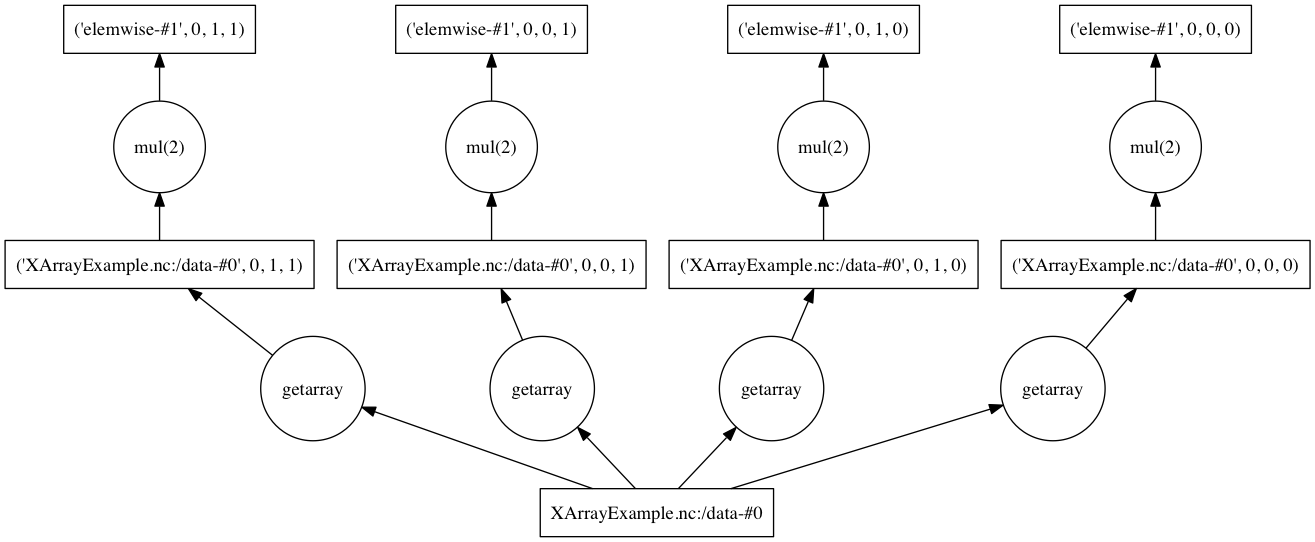

In [37]:
# We have to use the .data.dask attribute to get the graph when we're using dask through xarray
dot_graph(doubled.data.dask)

Now, this probably looks a bit strange...but follow it up from the bottom to the top. We start with the XArrayExample.nc file at the moment, and then split into four chunks using the `getarray` function. You can see that these have unique ids (`0,0,1,1`, `0,0,0,1` etc) which show where they are in the grid. We then use the `mul(2)` function, which multiplies by two, and then that's basically it...the outputs are _kept in the chunks_, so if we try and access a small part of the array, all it will need to do is use the specific chunk that it is in.

Now if we add a 'reduction' operation we can see how this changes the graph. In this case, lets take the minimum value of the doubled array:

In [38]:
min_doubled = (data * 2).min()

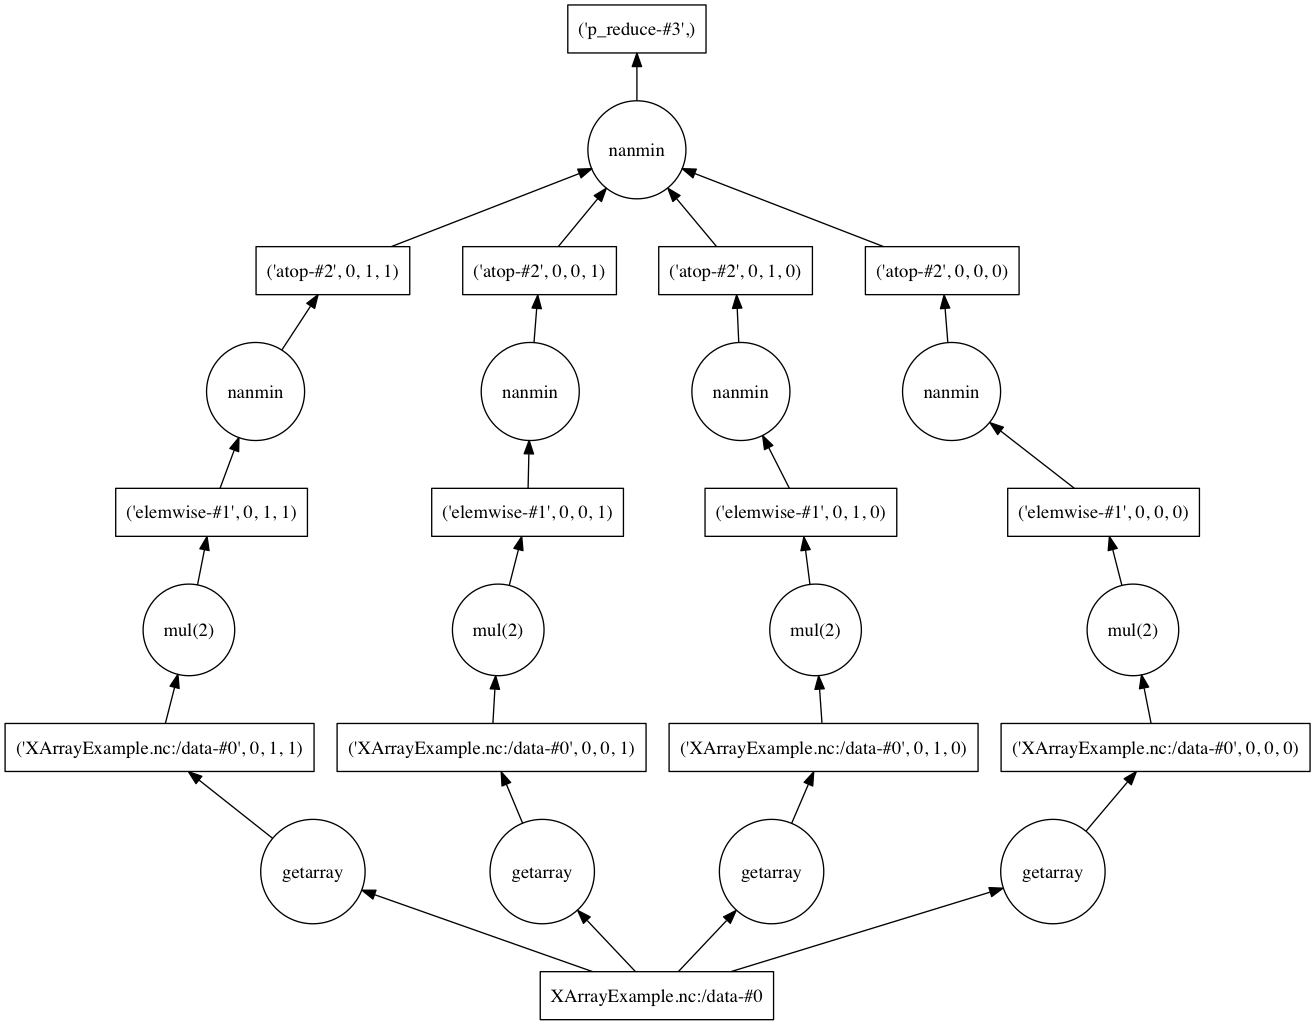

In [40]:
dot_graph(min_doubled.data.dask)

You can see that the bottom of the graph is basically the same, but then _each chunk_ is run through `nanmin` (which does a minimum after removing nan values), and then it calculates the minimum of the minimum from each chunk. That probably sounds confusing, so think about it for a moment: if you take the minimum of each chunk then the lowest of all of those will be the minimum of the overall dataset, yes?

We can do other examples here - and I'll let you play around a bit - but a couple of things that may be interesting:

In [41]:
mean_doubled = (data * 2).mean()

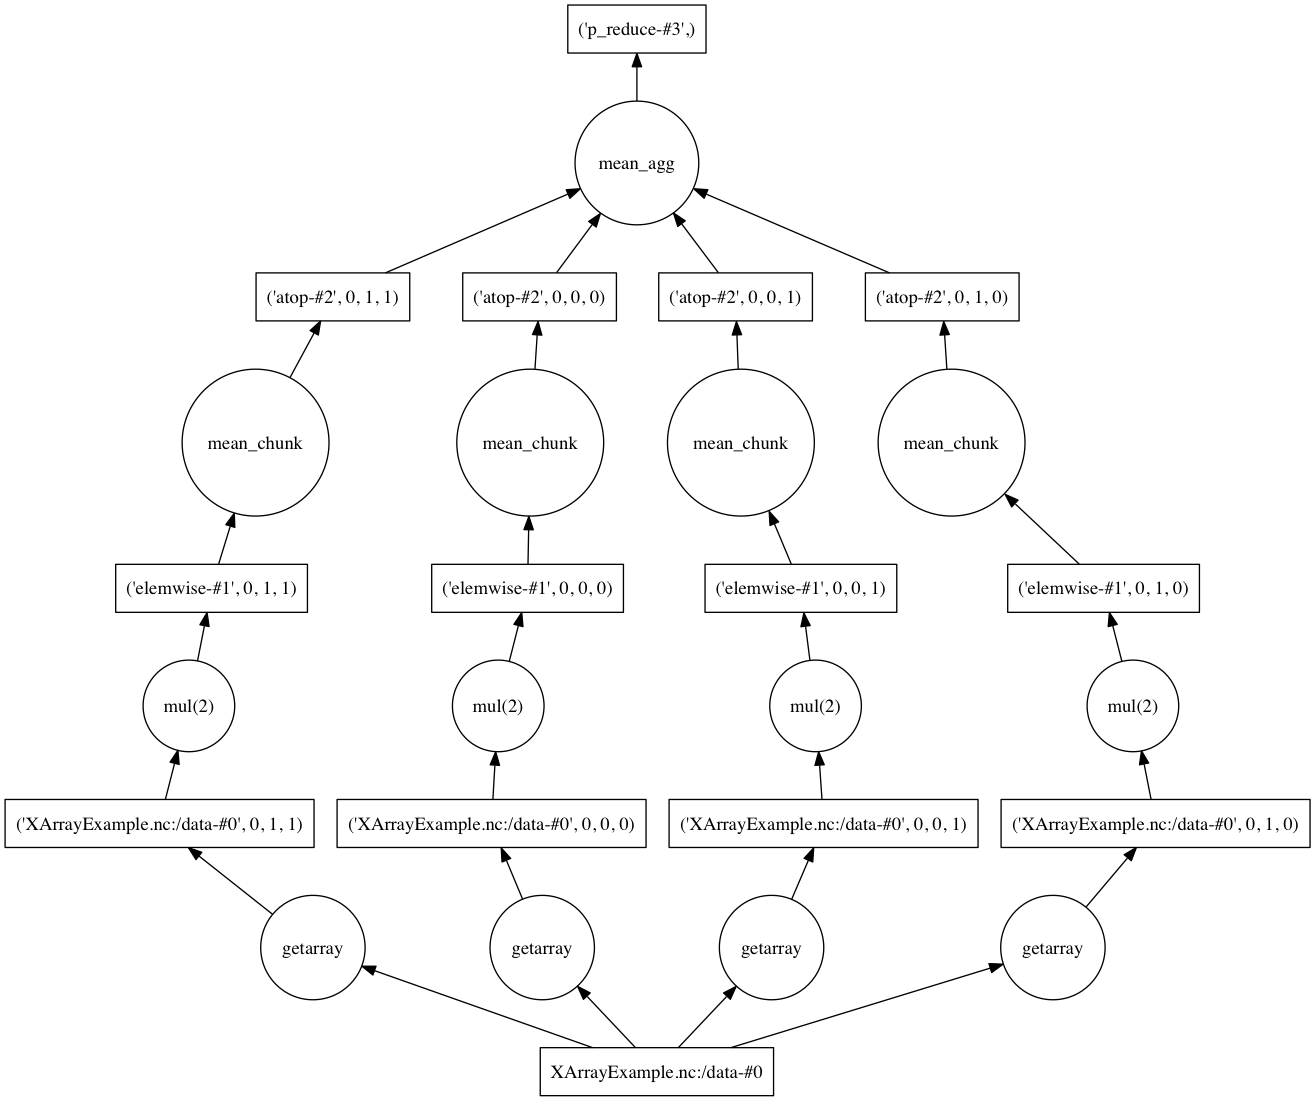

In [42]:
dot_graph(mean_doubled.data.dask)

The other key thing that we can do is load the datasets with different chunks and see what happens:

In [43]:
# Just chunk in the y direction
data = xr.open_dataset('XArrayExample.nc', chunks={'y': 50})['data']

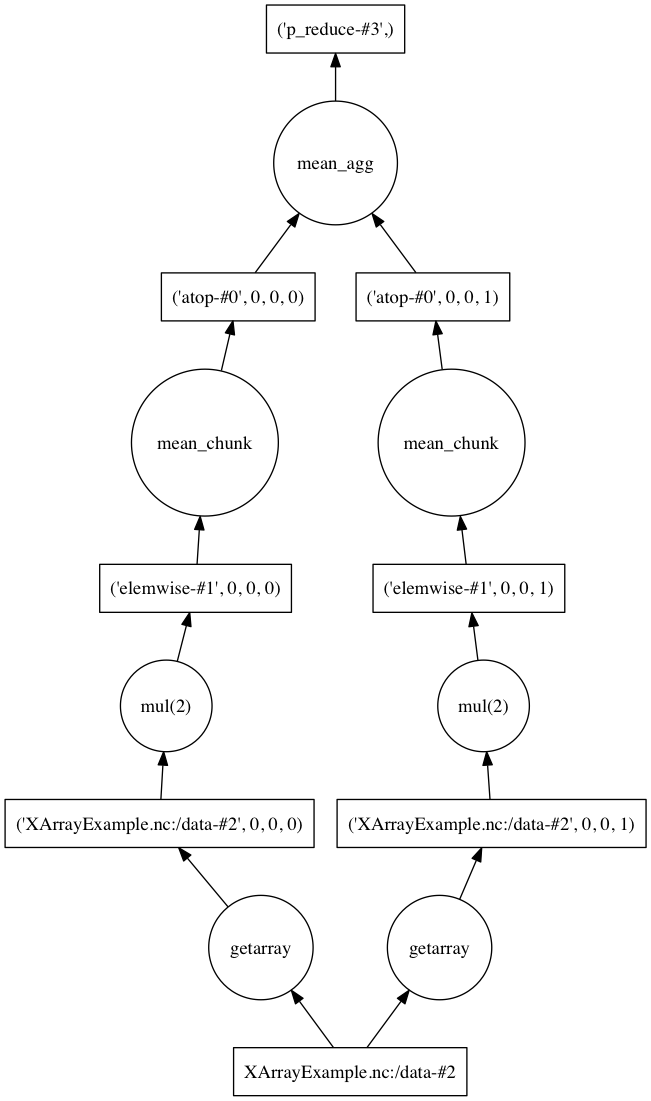

In [44]:
mean_doubled = (data * 2).mean()
dot_graph(mean_doubled.data.dask)

Or do a huge number of chunks:

In [47]:
data = xr.open_dataset('XArrayExample.nc', chunks={'x': 10, 'y': 30})['data']

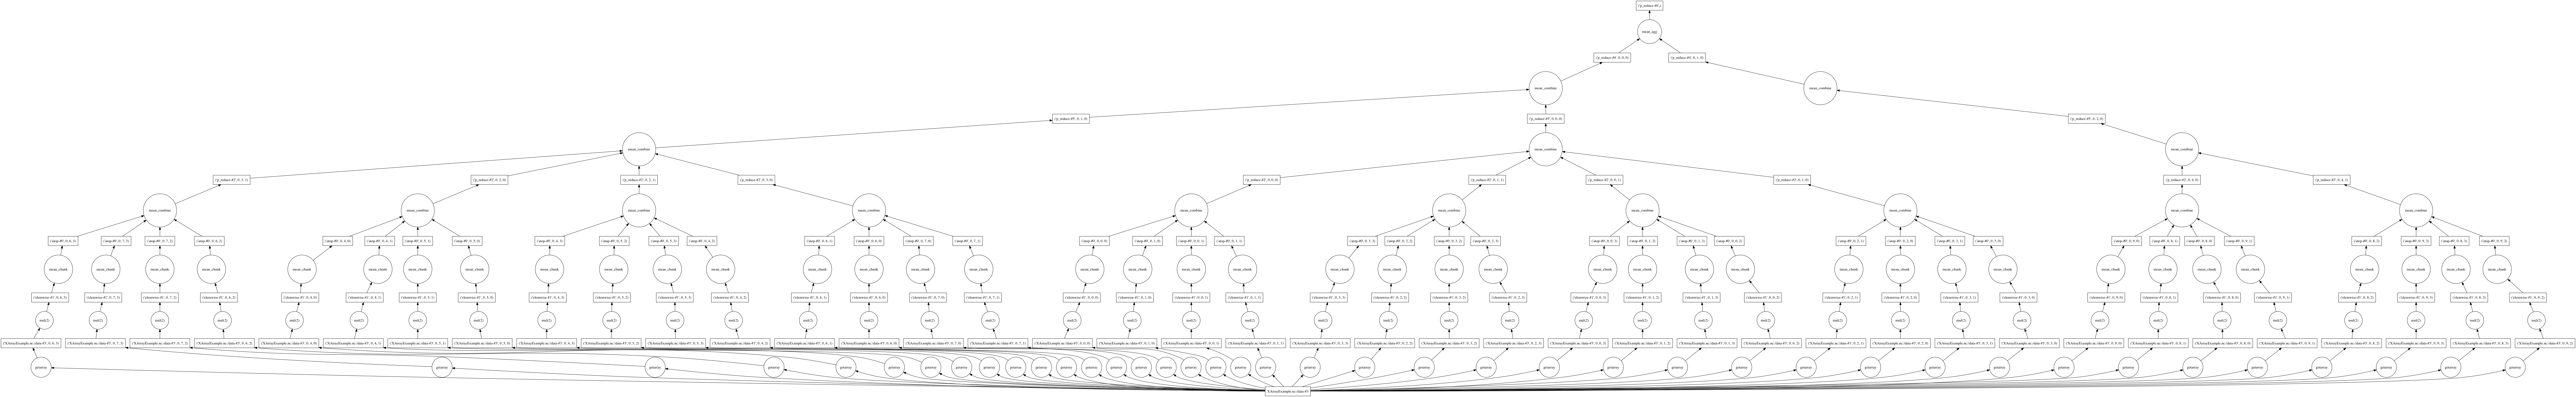

In [48]:
mean_doubled = (data * 2).mean()
dot_graph(mean_doubled.data.dask)

Now, what about accessing a specific bit of the array using xarray:

(We'll go back to a sensible number of chunks first!)

In [52]:
data = xr.open_dataset('XArrayExample.nc', chunks={'x': 50, 'y': 50})['data']

In [53]:
ts = data.isel(x=5, y=5)

For extra fun, lets multiply the time series here by two (for some insane reason):

In [55]:
ts = ts * 2

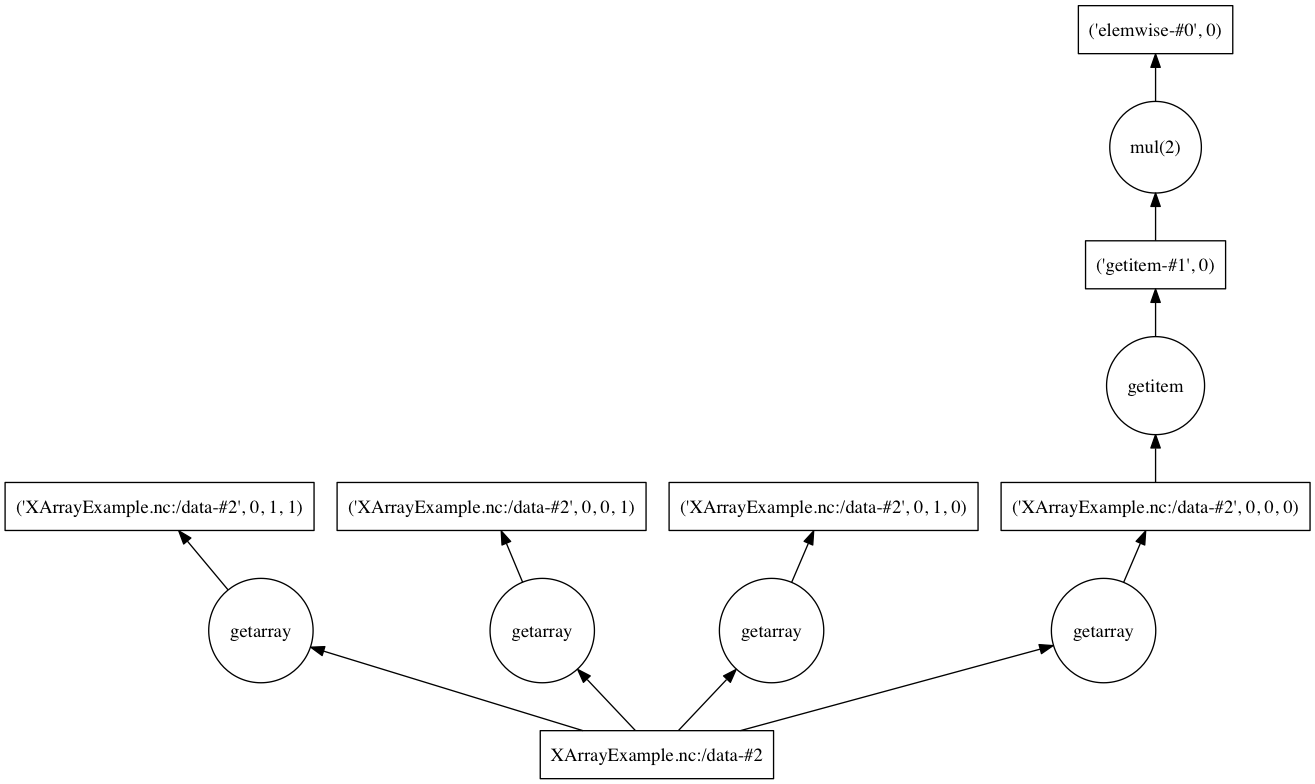

In [56]:
dot_graph(ts.data.dask)

Now see what happens there: the data is split into its chunks and then only the chunk that we want is actually multipled by two - clever! :-)

There are some other profiling things we can do - but we need a larger dataset so it actually takes a reasonable amount of time. So lets create one:

In [76]:
data = np.random.rand(10000, 10000)

In [77]:
b = xr.DataArray(data, dims=['x', 'y'], coords={'time':datetime(2010, 1, 4)})
c = xr.DataArray(data*2, dims=['x', 'y'], coords={'time':datetime(2010, 1, 5)})
d = xr.DataArray(data*3, dims=['x', 'y'], coords={'time':datetime(2010, 1, 6)})

In [78]:
a = xr.concat([b, c, d], 'time')

In [79]:
ds = a.to_dataset(name='data')

In [80]:
ds.to_netcdf('XArrayExample_Large.nc')

The bit below is hard to show within the notebook - I'll show you when we meet.

In [57]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

In [148]:
data = xr.open_dataset('XArrayExample_Large.nc', chunks={'x': 5000, 'y': 5000})['data']

In [149]:
res = (data * 2).mean()

In [150]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof:
        res.load()

In [151]:
from dask.diagnostics import visualize
b = visualize([prof, rprof, cprof])